# AI - Fall 00 - Computer Assignment 3

<div style="font-size: 16px">
<b>Paria Khoshtab 810198387</b>
<hr>
</div>

## Goal

The goal of this project is to get more familiar with a classification technique based on Bayes' Theorem with
an assumption of independence among predictors called a `Naive Bayes Classifier.`

## Brief Description

In this problem, we are given a training dataset (`divar_train.csv`) and a test dataset (`divar_test.csv`)
related to the advertisements on Divar, which is a platform for the free posting of advertisements.
In this project, we intend to use the 'Classifier Bayes Naive' to analyze the advertisements on the Divar site and 
categorize them.

## Modeling the Problem

We use <b>Bag-of-Words Naive Bayes</b> to predict classifications:<br>
- Features: $w_i$ is the word at position i<br>
- Assume features are conditionally independent given class c<br>
- All positions share the same conditional probs $p(w|c)$
- Generative model: $p(c, w_1, w_2...w_n) = p(c)\prod_{i=1}^np(w_i|c)$

<hr>

First we have to import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from __future__ import unicode_literals
from hazm import *
from parsivar import *
import string
from nltk.util import ngrams
from collections import Counter
import math
import matplotlib.pyplot as plt

In the code below, we read train and test CSV files and store them in data frames.

In [2]:
train_df = pd.read_csv("divar_train.csv")
test_df = pd.read_csv("divar_test.csv")

## Phase 1: Data Preprocessing

We normalize the titles and descriptions in the training and test data frames as much as possible by removing the 
stop words, nonsignificant characters, punctuation marks, English letters and digits, and Persian and Arabic digits. <br>

In [3]:
def normalize(sentence):
    special_chars = list(string.punctuation + string.ascii_lowercase + string.ascii_uppercase + string.digits)
    special_chars += ['،', '\n', '\r', '\b']
    special_chars += list(u'۱۲۳۴۵۶۷۸۹۰') +  list(u'١٢٣٤٥٦٧٨٩٠');
    sentence = sentence.translate ({ord(c): ' ' for c in special_chars})
    for sw in stopwords_list():
        sentence = sentence.replace(' ' + sw + ' ', ' ')
    return sentence   

train_df['title'] = train_df['title'].apply(normalize)
train_df['description'] = train_df['description'].apply(normalize)
test_df['title'] = test_df['title'].apply(normalize)
test_df['description'] = test_df['description'].apply(normalize)

We didn't use `Lemmatization`, `Stemming` and `Normalizing` in preposseing, but we can observe the effect of other types 
of preprocessing methods in hazm library:

Normalizer transforms one word with extra spaces into one word with half-spaces.

In [4]:
normalizer = Normalizer()
normalizer.normalize('اصلاح نويسه ها و استفاده از نیم‌فاصله پردازش را آسان مي كند')

'اصلاح نویسه\u200cها و استفاده از نیم\u200cفاصله پردازش را آسان می\u200cکند'

In [5]:
stemmer = Stemmer()
stemmer.stem ( 'دفتر ها' )

'دفتر '

In [6]:
lemmatizer = Lemmatizer()
lemmatizer.lemmatize ('رفتم')

'رفت#رو'

### Question 1

<b>Stemming</b> is a rule-based approach because it slices the inflected words from prefix or suffix as per the need using a
set of commonly underused prefix and suffix, like “-ing”, “-ed”, “-es”, “-pre”, etc. It results in a word that is actually not
a word.<br>
<b>Lemmatization</b> considers the context and
converts the word to its meaningful base form, which is called Lemma. After lemmatization,
we will be getting a valid word that means the same thing. Sometimes, 
the same word can have multiple different Lemmas. Identifying the Part of Speech tag for the word in that specific
context can help us. It is similar to stemming, in turn,
it gives the stripped word that has some dictionary meaning.<br>
For example, Lemmatization clearly identifies the base form of ‘troubled’ to ‘trouble’’ denoting some meaning whereas,
Stemming will cut out ‘ed’ part and convert it into ‘troubl’ which has the wrong meaning and spelling errors.<br>

## Phase 2: Problem process

### Question 2

- <b>Prior: </b> $p(c)$  is the prior probability of class, i.e. probability of class c(event) before text x(evidence) is
seen. This probability is calculated by dividing the number of texts whose class is c by the total number of texts in train
dataset(i.e. $\frac{count(c)}{len(train)}$)<br>

- <b>Likelihood: </b> $p(x|c)$ is the likelihood which is the probability of predictor given class, which here
    means the probability of text x given class c.This probability is calculated by multiplying the probability 
    of each word of the text x, given class c. Since in the Naive Bayes, these words are independent of each other,
    we have: $ p(x|c) = p(x_1|c)p(x_2|c)...p(x_n|c)$ where $p(x_i|c) = \frac{count(x_i,c)}{count(c)}$<br>
        
- <b>Evidence: </b>$p(x)$ is the prior probability of predictor, which here means The probability of seeing text x 
    in all existing class texts. This probability which is calculated by dividing the number of x texts by 
    the total number of texts in train dataset(i.e. $\frac{count(x)}{len(train)}$) <br>
    
- <b>Posterior: </b> $p(c|x)$ is the posterior probability of class c given sentence x, which consists of words $x_1, x_2...x_n$.
. This probability is calculated using the Bayes Theorem(i.e. $\frac{p(x|c)p(c)}{p(x)}$) <br>

Now, we can obtain the values for each by looking at the dataset and substitute them into the equation.
For all entries in the dataset, the denominator does not change, it remains static. Therefore, the denominator
can be removed and proportionality can be injected:<br>
$p(c|x) \sim p(x_1|c)p(x_2|c)...p(x_n|c)p(c)$<br>
we have to find the class variable(c) with maximum probability:<br>
$c = \operatorname{arg\,max}_c p(x_1|c)p(x_2|c)...p(x_n|c)p(c)$

For calculations, we merge the two columns of title and description, in which case we will have one column for the data.

In [7]:
train_df['data'] = train_df['title'] + " " + train_df['description']
train_df.drop(['title', 'description'], axis = 1, inplace = True)
test_df['data'] = test_df['title'] + " " + test_df['description']
test_df.drop(['title', 'description'], axis = 1, inplace = True)

First of all, we find the number of each word of given texts according to its class.
By doing this, we have somehow trained our model.

In [8]:
def create_dictionary(category):    
    data = train_df[train_df['categories'] == category]['data']
    words = []
    for text in data:
        tokens = word_tokenize(text)
        words += tokens
    return Counter(words)

In [9]:
categories = {}
for category in np.unique(train_df['categories']):
    categories[category] = create_dictionary(category)

We implement `posterior_probability` function which returns $p(c|x)$ based on above approach using Naive Bayes:

In [10]:
def posterior_probability(text, category_name, category_dict):       
    words = word_tokenize(text)
    posterior = len(train_df[train_df['categories'] == category_name])/len(train_df)
    for w in words:
        if w not in category_dict:
            posterior = 0
            break
        posterior *= category_dict[w]/sum(category_dict.values())
    return posterior

We implement `predict_category` which returns the class with highest posterior probability, given text.

In [11]:
def predict_category(text):
    max_prob = -math.inf
    category = None
    for name in categories:
        posterior = posterior_probability(text, name, categories[name])
        if posterior > max_prob:
            max_prob = posterior
            category = name
    return category

For example we have:

In [12]:
text = test_df['data'][0]
print('text: ', text)
print('predicted category: ', predict_category(text))
print('actual category: ', test_df['categories'][0])

text:  کیف مجلسی نو کیف مجلسی نوی نو
predicted category:  personal
actual category:  personal


## Bigrams

### Question 3

<b></b> Technically, almost every word has multiple meanings, for example:<br>

- Her favorite fruit to eat is a date.<br>
- What is your date of birth?<br>

For any artificial intelligence or machine learning model,
we need to train the model with a huge corpus of data. Once we do that, the system will have a
pretty good idea of the “probability” of the occurrence of a word after or before a certain word. 
So hoping that we have trained our model with a huge corpus of data, we’ll assume that the model gave us the correct answer.
so:<br>
- It can help in deciding which bigrams can be chunked together to form single entities.<br>
- It can also help make next word predictions.<br>
- It can also help to make spelling error corrections.<br>

Bigram is not enough to specify the meaning of the word(“date”) in my example and it requires a longer n-gram because words before
and after “date” in the sentences are {'a', '.', 'your', 'of'} which can't specify the meaning. But if we do preprocessing by
removing stop words and punctuations, words before and after “date” in the sentences will be {'eat', 'your', 'birth'}, in this
case bigram is enough for specifying the meaning of the word because “birth” has a high probability of occurrence after the word
“date” , meaning the day of the month or year as specified by a number. Also “eat” has a high probability of occurrence 
before the word “date”, meaning a sweet, dark brown oval fruit containing a hard stone.

In [13]:
def get_bigrams(category):    
    data = train_df[train_df['categories'] == category]['data']
    word_list = []
    for d in data:
        words = word_tokenize(d)
        bigrams = list(ngrams(words, 2))
        word_list += bigrams
    return word_list

## Additive Smoothing

### Question 4

In Bag-of-Words Naive Bayes model, the maximum likelihood estimator for $p(w|c)$ is $\frac{count(w,c)}{count(c)}$, where w is
a word and c is a class. This estimation of $p(w|c)$ could be problematic because 
it would give us probability 0 for documents with unknown words. since we multiply all the likelihoods, this is the problem
of zero probability, and we are unable to be sure about the prediction, so our model will perform poorly.<br>
Therefore, the problem mentioned in the question, is due to the fact that the probability $p(w|c)$ for all classes except the "vehicles"
class is zero, and we only have a greater probability of one per "vehicles" class. Since this model selects the class with
the highest probability, for all texts including the word "tire", the "vehicles" class will be selected, which is not necessarily
correct.

### Question 5

A common way of solving this problem is to use additive smoothing:<br>
Let V be the set of words in the training set(vocabulary), add a new element (for unknown) to the set of words, Define:<br>
$p(w|c) = \frac{count(w,c) + 1}{count(c) + |V| + 1}$<br>
In particular, any unknown word will have probability $p(w|c) = \frac{1}{count(c) + |V| + 1}$<br> which is not 0 and solves the
problem.

We implement `posterior_probability_AS` function which returns  $𝑝(𝑐|𝑥)$  based on additive smoothing method:

In [14]:
def posterior_probability_AS(sentence, category_name, category_dict):       
    words = word_tokenize(sentence)
    posterior = len(train_df[train_df['categories'] == category_name])/len(train_df)
    
    V = len({**categories['businesses'], **categories['electronic-devices'], **categories['for-the-home'], \
             **categories['leisure-hobbies'], **categories['personal'], **categories['vehicles']})
    
    for w in words:
        count_w_c = 0
        if w in category_dict:
            count_w_c = category_dict[w]
        posterior *= (count_w_c + 1)/(sum(category_dict.values()) + V + 1)
    return posterior

We implement `predict_category_AS` which returns the class with highest posterior probability based on additive smooting method, 
given text.

In [15]:
def predict_category_AS(text):
    max_prob = -math.inf
    category = None
    for name in categories:
        posterior = posterior_probability_AS(text, name, categories[name])
        if posterior > max_prob:
            max_prob = posterior
            category = name
    return category

For example we have:

In [16]:
text = test_df['data'][1]
print('text: ', text)
print('predicted category: ', predict_category_AS(text))
print('actual category: ', test_df['categories'][1])

text:  دیوار کوب نمدی تزیینی مناسب جهاز عروس
predicted category:  for-the-home
actual category:  for-the-home


## Verification

### Question 6

First we sort the dictionaries by value in descending order and then we plot a diagram of the first 5 words
for each dictionary.

businesses ['فروش', 'عدد', 'دستگاه', 'نو', 'قیمت']


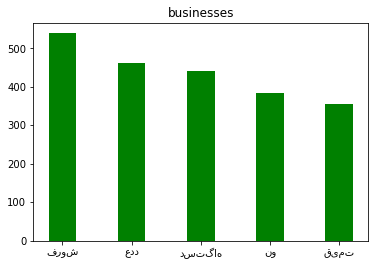

electronic-devices ['گوشی', 'سالم', 'تمیز', 'نو', 'قیمت']


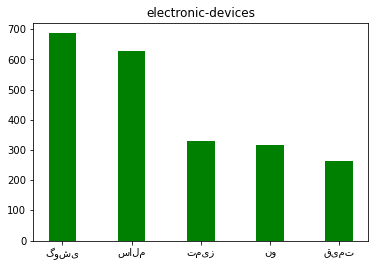

for-the-home ['سالم', 'نو', 'میز', 'نفره', 'مبل']


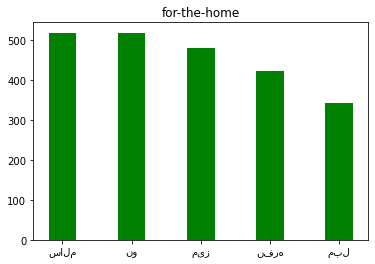

leisure-hobbies ['سالم', 'جفت', 'نر', 'دوچرخه', 'ماده']


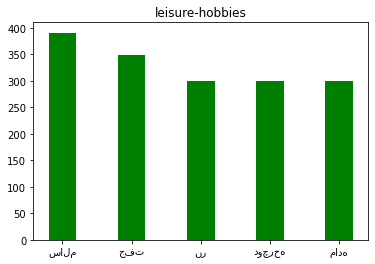

personal ['نو', 'سایز', 'لباس', 'کفش', 'قیمت']


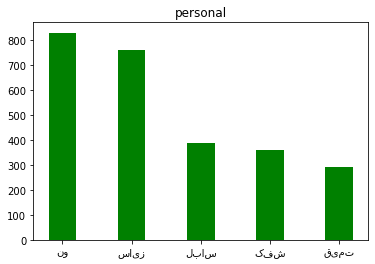

vehicles ['بیمه', 'سالم', 'رنگ', 'مدل', 'سال']


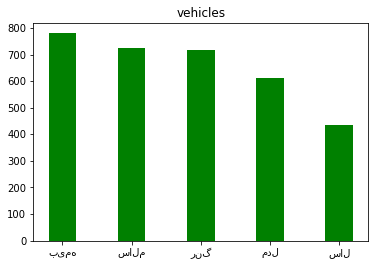

In [17]:
sorted_vehicles = dict(sorted(categories['vehicles'].items(), key=lambda item: item[1], reverse=True))

for name, dictionary in categories.items():
    sorted_category = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
    words = list(sorted_category.keys())[0:5]
    values = list(sorted_category.values())[0:5]
    print(name, words)
    plt.title(name)
    plt.bar(words, values, color ='green', width = 0.4)
    plt.show()  

As shown above, some words in all categories have a high number of repetitions, as a result of which they have no
effect on identifying the category for the advertisement. In this case, removing these words from the vocabulary could 
be a good option.

## Phase 3: Evaluation

In [18]:
def accuracy(prediction):
    correct_detected = 0
    total = len(test_df)
    for row in test_df.index:
        if test_df['categories'][row] == test_df[prediction][row]:
            correct_detected += 1
    return correct_detected / total

def precision(prediction):
    precisions = {}
    for name in categories:
        correct_detected = len(test_df[(test_df['categories'] == name) & (test_df[prediction] == name)])
        all_detected = len(test_df[test_df[prediction] == name])
        p = correct_detected / all_detected
        precisions[name] = p
    return precisions

def recall(prediction):
    recalls = {}
    for name in categories:
        correct_detected = len(test_df[(test_df['categories'] == name) & (test_df[prediction] == name)])
        total_class = len(test_df[test_df['categories'] == name])
        r = correct_detected / total_class
        recalls[name] = r
    return recalls
                                  
def F1_score(prediction):
    scores = {}
    precisions = precision(prediction)
    recalls = recall(prediction)
    for name in categories:
        f1 = 2 * (precisions[name] * recalls[name]) / (precisions[name] + recalls[name])
        scores[name] = f1
    return scores  

### Question 7

Because, precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means 
that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns 
most of the relevant results (whether or not irrelevant ones are also returned) So we need a tradeoff between precision and
recall for the model in order to work well. For example: <br>
    
- Assume we have a model that predicts wheather a patient has covid-19 or not and just says one patient has 
covid-19 an he has it truly. In this case, our precision is 100% but we may miss prediction of having covid-19 for 
other patients.<br><br>

- Assume The surgeon needs to remove all of the tumour cells in brain and must not remove healthy brain cells. If the surgeon
acts freely in the area of the brain, he removes to ensure he has extracted all the cancer cells, so he
may remove healty brain cells as well. This decision increases recall but reduces precision.

### Question 8

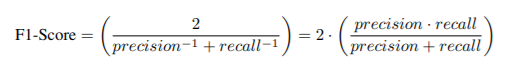

F1 Score is the harmonic average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 
Similar to arithmetic mean, the F1-score will always be somewhere in between precision and recall. But it behaves differently: the F1-score gives a larger weight to lower numbers.
We use F1 score instead of a simple average because it punishes extreme values. It is never higher than the geometrical mean. It also tends towards the least number, minimizing the impact of the large outliers and maximizing the impact of small ones.
F1 is usually useful when we have an uneven class distribution.          

### Question 9

<b> Macro </b><br>

- Macro-averaged F1-score(macro-F1): an arithmetic mean of the per-class F1-scores<br>
- Macro-averaged precision: an arithmetic mean of the per-class precisions<br>
- Macro-averaged recall: an arithmetic mean of the per-class recalls<br>
    
It is possible to derive some intuitions from the equation.
Macro-Average methods tend to calculate an overall mean of different measures,
because the numerators of Macro Average Precision and Macro Average Recall are composed by values in the range [0,1].
There is no link to the class size, because classes with different size are equally weighted at the numerator.
This implies that the effect of the biggest classes have the same importance as small ones have. The obtained metric 
evaluates the algorithm from a class standpoint: high Macro-F1 values indicate that the algorithm has good performance on
all the classes, whereas low Macro-F1 values refers to poorly predicted classes.<br><br>

<b> Micro </b><br>
- Micro-F1 = Micro-precision = Micro-recall = Accuracy: the proportion of correctly classified samples out of all the samples.
<br>

Micro-Average F1-Score is just equal to Accuracy. Hence, pros and cons are shared between the two measures.
Both of them give more importance to big classes, because they just consider all the units together. In fact a 
poor performance on small classes is not so important, since the number of units belonging to those classes is small 
compared to the dataset size.<br><br>
    
<b> Weighted </b><br>
- weighted-average F1-score(weighted-F1): we weight the F1-score of each class by the number of samples from that class.<br>
- Weighted-precision: we weight the precision of each class by the number of samples from that class.<br>
- Weighted-recall: we weight the recall of each class by the number of samples from that class.<br>
    
Weighted-average keeps track of the importance of each class thanks
to the frequency. In this case, large and small classes have a proportional effect on the result in relation to
their size and the metric can be applied during the training phase of the algorithm on a wide number of classes.  

In [19]:
def macro_F1(prediction):
    f1_scores = F1_score(prediction)
    return sum(f1_scores.values())/len(f1_scores)

def macro_precision(prediction):
    precisions = precision(prediction)
    return sum(precisions.values())/len(precisions)

def macro_recall(prediction):
    recalls = recall(prediction)
    return sum(recalls.values())/len(recalls)

def weighted_F1(prediction):
    result = 0
    for category, score in F1_score(prediction).items():
        result += len(test_df[test_df['categories'] == category]) * score
    return result/len(test_df)
                      
def weighted_precision(prediction):
    result = 0 
    for category, prec in precision(prediction).items():
        result += len(test_df[test_df['categories'] == category]) * prec
    return result/len(test_df)

def weighted_recall(prediction):
    result = 0 
    for category, rec in recall(prediction).items():
        result += len(test_df[test_df['categories'] == category]) * rec
    return result/len(test_df)                      

We store the results of our classification in two new columns of test dataframe called `predicted-category-1`
(without additive smooting) and `predicted-category-2` (with additive smooting)

In [20]:
test_df['predicted-category-1'] = test_df['data'].apply(predict_category)
test_df['predicted-category-2'] = test_df['data'].apply(predict_category_AS)

### Question 10

### A) results with using additive smoothing

#### Accuracy

In [21]:
print(accuracy('predicted-category-2'))

0.8705555555555555


#### Precision

In [22]:
for category, p in precision('predicted-category-2').items():
    print(category, ':', p)

businesses : 0.788961038961039
electronic-devices : 0.8928571428571429
for-the-home : 0.8349514563106796
leisure-hobbies : 0.939622641509434
personal : 0.867741935483871
vehicles : 0.91


#### Recall

In [23]:
for category, r in recall('predicted-category-2').items():
    print(category, ':', r)

businesses : 0.81
electronic-devices : 0.9166666666666666
for-the-home : 0.86
leisure-hobbies : 0.83
personal : 0.8966666666666666
vehicles : 0.91


#### F1-score

In [24]:
for category, s in F1_score('predicted-category-2').items():
    print(category, ':', s)

businesses : 0.799342105263158
electronic-devices : 0.9046052631578947
for-the-home : 0.8472906403940887
leisure-hobbies : 0.8814159292035398
personal : 0.8819672131147541
vehicles : 0.91


#### Macro

In [25]:
print('Macro F1 :', macro_F1('predicted-category-2'))
print('Macro precision :', macro_precision('predicted-category-2'))
print('Macro recall :', macro_recall('predicted-category-2'))

Macro F1 : 0.8707701918555726
Macro precision : 0.8723557025203611
Macro recall : 0.8705555555555556


#### Micro

In [26]:
print('Micro F1 = Micro precision = Micro recall =', accuracy('predicted-category-2'))

Micro F1 = Micro precision = Micro recall = 0.8705555555555555


#### Weighted

In [27]:
print('Weighted F1 :', weighted_F1('predicted-category-2'))
print('Weighted precision :', weighted_precision('predicted-category-2'))
print('Weighted recall :', weighted_recall('predicted-category-2'))

Weighted F1 : 0.8707701918555726
Weighted precision : 0.872355702520361
Weighted recall : 0.8705555555555555


### B) results without using additive smoothing

#### Accuracy

In [28]:
print(accuracy('predicted-category-1'))

0.46


#### Precision

In [29]:
for category, p in precision('predicted-category-1').items():
    print(category, ':', p)

businesses : 0.23574468085106384
electronic-devices : 0.8991596638655462
for-the-home : 0.8482758620689655
leisure-hobbies : 0.7802197802197802
personal : 0.9154929577464789
vehicles : 0.9375


#### Recall

In [30]:
for category, r in recall('predicted-category-1').items():
    print(category, ':', r)

businesses : 0.9233333333333333
electronic-devices : 0.3566666666666667
for-the-home : 0.41
leisure-hobbies : 0.23666666666666666
personal : 0.43333333333333335
vehicles : 0.4


#### F1-score

In [31]:
for category, s in F1_score('predicted-category-1').items():
    print(category, ':', s)

businesses : 0.375593220338983
electronic-devices : 0.5107398568019093
for-the-home : 0.5528089887640449
leisure-hobbies : 0.3631713554987212
personal : 0.5882352941176471
vehicles : 0.5607476635514019


#### Macro

In [32]:
print('Macro F1 :', macro_F1('predicted-category-1'))
print('Macro precision :', macro_precision('predicted-category-1'))
print('Macro recall :', macro_recall('predicted-category-1'))

Macro F1 : 0.4918827298454513
Macro precision : 0.7693988241253059
Macro recall : 0.45999999999999996


#### Micro

In [33]:
print('Micro F1 = Micro precision = Micro recall =', accuracy('predicted-category-1'))

Micro F1 = Micro precision = Micro recall = 0.46


#### Weighted

In [34]:
print('Weighted F1 :', weighted_F1('predicted-category-1'))
print('Weighted precision :', weighted_precision('predicted-category-1'))
print('Weighted recall :', weighted_recall('predicted-category-1'))

Weighted F1 : 0.4918827298454513
Weighted precision : 0.7693988241253058
Weighted recall : 0.46


### Question 11

On average, the results obtained from the smoothing method have a higher score, for example, the accuracy with 
the smoothing method is 0.87, while without using this method, it is 0.46. Also, in the results of both methods, 
the averages calculated with the three methods mentioned, are much close to each other because all classes in our 
test dataframe have the same number, resulting in same weight, so practically, in this special case, the weighted method is
the same as the macro method. We can also intuitively observe that there is a tradeoff between the precision and recall.

### Question 12

We show 5 advetisements below, that the real category of them is `vehicles`, but we have labeled them other than
`vehicles`.

In [35]:
false_predictions = test_df[(test_df['categories'] == 'vehicles') & (test_df['predicted-category-2'] != 'vehicles')]
false_predictions.head(5)

,categories,data,predicted-category-1,predicted-category-2
133,vehicles,فروش یکجای لوازم اوراقی انواع خودرو تمامی لواز...,businesses,businesses
193,vehicles,یک جفت تمیز زدگی خط خش هف...,electronic-devices,electronic-devices
363,vehicles,ظبط پایونر سالم سالم الان نصب هست ماشین شرط تس...,businesses,electronic-devices
368,vehicles,موستانگ سفید آبی بسیار است,businesses,leisure-hobbies
391,vehicles,شمع های سوزنی پخش انواع شمعهای سوزنی اریدیوم د...,businesses,businesses


The assumptions made by Naive Bayes are not necessarily correct because Naive Bayes assumes that all predictors 
(or features) are independent, rarely happening in real life.
This limits the applicability of this algorithm in real-world use cases but often works well in practice.
In fact, in the bag-of-words model, all words are considered independent of their position and independent of each other, while in real-world texts, words and their position are not independent, and we also used Unigram tokens in this question, which again ignores the dependence of words. These problems may cause the algorithm to fail in some tests and predict wrongly.

## Conclusion

- It is easy and fast to predict the class of the test data set. It also performs well in multi-class prediction.<br>
- If categorical variable has a category (in test data set), which was not observed in training data set, 
then model will assign a 0 (zero) probability and will be unable to make a prediction.
To solve this, we can use the additive smoothing technique.<br>
- One of the limitations of Naive Bayes is the assumption of independent predictors. 
In real life, it is almost impossible that we get a set of predictors which are completely independent.